In [1]:
import scipy.sparse
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_validate
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV

In [2]:
train_df = pd.read_csv('project_data_files/book_rating_train.csv')
test_df = pd.read_csv('project_data_files/book_rating_test.csv')

In [3]:
train_df = train_df.drop(columns=['Language', 'PublishDay', 'Name', 'Authors', 'Description'], axis=1)
train_df.head()

,PublishYear,PublishMonth,Publisher,pagesNumber,rating_label
0,2005,6,Teaching Resources,48,4.0
1,1991,10,DoubleDay,364,4.0
2,2005,3,Chronicle Books,32,4.0
3,2004,9,Bison Books,293,4.0
4,2005,7,Penguin Books Ltd,352,3.0


In [4]:
# see if there are any null values
train_df.isnull().sum()

PublishYear       0
PublishMonth      0
Publisher       148
pagesNumber       0
rating_label      0
dtype: int64

In [5]:
train_df['PublishSeason'] = train_df['PublishMonth'].apply(lambda x: '1' if x in [1, 2, 3] else '2' if x in [4, 5, 6] else '3' if x in [7, 8, 9] else '4')
train_df

,PublishYear,PublishMonth,Publisher,pagesNumber,rating_label,PublishSeason
0,2005,6,Teaching Resources,48,4.0,2
1,1991,10,DoubleDay,364,4.0,4
2,2005,3,Chronicle Books,32,4.0,1
3,2004,9,Bison Books,293,4.0,3
4,2005,7,Penguin Books Ltd,352,3.0,3
...,...,...,...,...,...,...
23058,1997,8,2.13.61,120,4.0,3
23059,2005,6,HMH Books for Young Readers,32,4.0,2
23060,1989,2,Rowman & Littlefield Publishers,132,4.0,1
23061,1998,4,New Amsterdam Books,136,4.0,2


In [6]:
train_df['pagesNumber'] = train_df['pagesNumber'].apply(lambda x: np.nan if x < 10 else x)

In [7]:
mean = train_df['pagesNumber'].mean()
sd = train_df['pagesNumber'].std()
train_df = train_df[train_df['pagesNumber'] <= mean + 3 * sd]
train_df = train_df[train_df['pagesNumber'] >= mean - 3 * sd]
train_df

,PublishYear,PublishMonth,Publisher,pagesNumber,rating_label,PublishSeason
0,2005,6,Teaching Resources,48.0,4.0,2
1,1991,10,DoubleDay,364.0,4.0,4
2,2005,3,Chronicle Books,32.0,4.0,1
3,2004,9,Bison Books,293.0,4.0,3
4,2005,7,Penguin Books Ltd,352.0,3.0,3
...,...,...,...,...,...,...
23058,1997,8,2.13.61,120.0,4.0,3
23059,2005,6,HMH Books for Young Readers,32.0,4.0,2
23060,1989,2,Rowman & Littlefield Publishers,132.0,4.0,1
23061,1998,4,New Amsterdam Books,136.0,4.0,2


In [8]:
mean = train_df['pagesNumber'].mean()
print(mean)
train_df['pagesNumber'] = train_df['pagesNumber'].fillna(mean)
train_df

275.9122690709803


,PublishYear,PublishMonth,Publisher,pagesNumber,rating_label,PublishSeason
0,2005,6,Teaching Resources,48.0,4.0,2
1,1991,10,DoubleDay,364.0,4.0,4
2,2005,3,Chronicle Books,32.0,4.0,1
3,2004,9,Bison Books,293.0,4.0,3
4,2005,7,Penguin Books Ltd,352.0,3.0,3
...,...,...,...,...,...,...
23058,1997,8,2.13.61,120.0,4.0,3
23059,2005,6,HMH Books for Young Readers,32.0,4.0,2
23060,1989,2,Rowman & Littlefield Publishers,132.0,4.0,1
23061,1998,4,New Amsterdam Books,136.0,4.0,2


In [9]:
# fill null publishers with 'Unknown'
train_df['Publisher'] = train_df['Publisher'].fillna('Unknown')

In [10]:
data_df = train_df['Publisher'].value_counts()
data_df.shape


(4185,)

In [11]:
# count the number of publishers that have less than 10 books
data_df[data_df < 10].shape

(3677,)

In [12]:
# mark publishers that have less than 10 books as 'Other'
train_df['Publisher'] = train_df['Publisher'].apply(lambda x: 'Other' if x in data_df[data_df < 10].index else x)

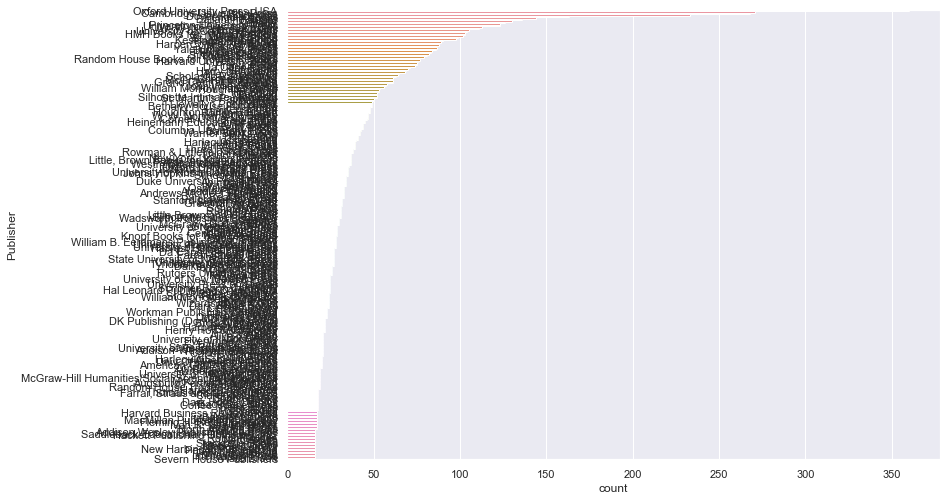

In [50]:
# draw distribution plot for publishers
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
# sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.countplot(y="Publisher", data=train_df, order=train_df['Publisher'].value_counts().iloc[:300].index)
plt.show()

In [13]:
# encode publisher with ordinal encoding
train_df['Publisher'] = train_df['Publisher'].astype('category')
train_df['Publisher'] = train_df['Publisher'].cat.codes
train_df

,PublishYear,PublishMonth,Publisher,pagesNumber,rating_label,PublishSeason
0,2005,6,302,48.0,4.0,2
1,1991,10,302,364.0,4.0,4
2,2005,3,83,32.0,4.0,1
3,2004,9,57,293.0,4.0,3
4,2005,7,313,352.0,3.0,3
...,...,...,...,...,...,...
23058,1997,8,302,120.0,4.0,3
23059,2005,6,163,32.0,4.0,2
23060,1989,2,356,132.0,4.0,1
23061,1998,4,302,136.0,4.0,2


In [14]:
y_train = train_df['rating_label']
# y_test = test_df['rating_label']

X_train = train_df.drop(['rating_label'], axis=1)

In [15]:
X_train.isna().sum()

PublishYear      0
PublishMonth     0
Publisher        0
pagesNumber      0
PublishSeason    0
dtype: int64

In [16]:
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
mi = SelectKBest(mutual_info_classif, k=2)
X_train_mi = mi.fit_transform(X_train, y_train)

X_train_mi = pd.DataFrame(X_train_mi)
X_train_mi.head()

,0,1
0,302,48.0
1,302,364.0
2,83,32.0
3,57,293.0
4,313,352.0


In [17]:
x2 = SelectKBest(chi2, k=2)
X_train_x2 = x2.fit_transform(X_train, y_train)

X_train_x2 = pd.DataFrame(X_train_x2)
X_train_x2.head()

,0,1
0,302,48.0
1,302,364.0
2,83,32.0
3,57,293.0
4,313,352.0


In [18]:
X_train

,PublishYear,PublishMonth,Publisher,pagesNumber,PublishSeason
0,2005,6,302,48.0,2
1,1991,10,302,364.0,4
2,2005,3,83,32.0,1
3,2004,9,57,293.0,3
4,2005,7,313,352.0,3
...,...,...,...,...,...
23058,1997,8,302,120.0,3
23059,2005,6,163,32.0,2
23060,1989,2,356,132.0,1
23061,1998,4,302,136.0,2


In [19]:
# use one hot encoder for publisher
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
# fit X_train
enc.fit(X_train[['Publisher']])
# # get feature names
feature_names = enc.get_feature_names_out(['Publisher'])
# # transform X_train
X_train_ohe = enc.transform(X_train[['Publisher']])
X_train_ohe = pd.DataFrame.sparse.from_spmatrix(X_train_ohe)
X_train_ohe.columns = feature_names
X_train_ohe

,Publisher_0,Publisher_1,Publisher_2,Publisher_3,Publisher_4,Publisher_5,Publisher_6,Publisher_7,Publisher_8,Publisher_9,...,Publisher_499,Publisher_500,Publisher_501,Publisher_502,Publisher_503,Publisher_504,Publisher_505,Publisher_506,Publisher_507,Publisher_508
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22621,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22622,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22623,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22624,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
X_train_ohe.isna().sum()[X_train_ohe.isna().sum() > 0]

Series([], dtype: int32)

In [21]:
# concat X_train_ohe with X_train
X_train_ohe_df = pd.concat([X_train.reset_index(drop=True), X_train_ohe.reset_index(drop=True)], axis=1)
X_train_ohe_df = X_train_ohe_df.drop(columns=['Publisher'])
X_train_ohe_df


,PublishYear,PublishMonth,pagesNumber,PublishSeason,Publisher_0,Publisher_1,Publisher_2,Publisher_3,Publisher_4,Publisher_5,...,Publisher_499,Publisher_500,Publisher_501,Publisher_502,Publisher_503,Publisher_504,Publisher_505,Publisher_506,Publisher_507,Publisher_508
0,2005,6,48.0,2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1991,10,364.0,4,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2005,3,32.0,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2004,9,293.0,3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2005,7,352.0,3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22621,1997,8,120.0,3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22622,2005,6,32.0,2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22623,1989,2,132.0,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22624,1998,4,136.0,2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
# check null values
X_train_ohe.isnull().sum()

Publisher_1st World Library - Literary Society      0
Publisher_ADV Manga                                 0
Publisher_AMACOM/American Management Association    0
Publisher_Abbeville Press                           0
Publisher_Abingdon Press                            0
                                                   ..
Publisher_Zondervan Academic                        0
Publisher_Zondervan Publishing Company              0
Publisher_eReads.com                                0
Publisher_iBooks                                    0
Publisher_iUniverse                                 0
Length: 509, dtype: int32

In [22]:
# do feature selection on X_train_ohe
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
mi = SelectKBest(mutual_info_classif, k=450)
X_train_ohe_mi = mi.fit_transform(X_train_ohe, y_train)
X_train_ohe_mi = pd.DataFrame.sparse.from_spmatrix(X_train_ohe_mi)
X_train_ohe_mi.columns = X_train_ohe.columns[mi.get_support()]
X_train_ohe_mi.head()

,Publisher_0,Publisher_1,Publisher_2,Publisher_3,Publisher_4,Publisher_5,Publisher_6,Publisher_7,Publisher_8,Publisher_9,...,Publisher_499,Publisher_500,Publisher_501,Publisher_502,Publisher_503,Publisher_504,Publisher_505,Publisher_506,Publisher_507,Publisher_508
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
X_train_ohe_df.drop(columns=['PublishMonth', 'PublishYear', 'PublishSeason'], axis=1, inplace=True)
X_train_ohe_df

,pagesNumber,Publisher_0,Publisher_1,Publisher_2,Publisher_3,Publisher_4,Publisher_5,Publisher_6,Publisher_7,Publisher_8,...,Publisher_499,Publisher_500,Publisher_501,Publisher_502,Publisher_503,Publisher_504,Publisher_505,Publisher_506,Publisher_507,Publisher_508
0,48.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,364.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,293.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,352.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22621,120.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22622,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22623,132.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22624,136.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
# results without author
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_validate

knn = KNeighborsClassifier(n_neighbors=5)
cv_results = cross_validate(knn, X_train_ohe_df, y_train, cv=5, scoring=('accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'), n_jobs=-1)
print(f"accuracy: {cv_results['test_accuracy'].mean()}, precision: {cv_results['test_precision_weighted'].mean()}, recall: {cv_results['test_recall_weighted'].mean()}, f1: {cv_results['test_f1_weighted'].mean()}")
print(f"accuracy_sd: {cv_results['test_accuracy'].std()}, precision_sd: {cv_results['test_precision_weighted'].std()}, recall_sd: {cv_results['test_recall_weighted'].std()}, f1_sd: {cv_results['test_f1_weighted'].std()}")

accuracy: 0.6452311726232474, precision: 0.586677965289606, recall: 0.6452311726232474, f1: 0.6089119352621768
accuracy_sd: 0.0035763618875851062, precision_sd: 0.005500212435585314, recall_sd: 0.0035763618875851062, f1_sd: 0.0035089056378760455


In [25]:
author_vec = pd.read_csv(r"project_data_files/book_text_features_doc2vec/book_text_features_doc2vec/train_authors_doc2vec20.csv", index_col = False, delimiter = ',', header=None)
for i in range(20):
    X_train_ohe_df['Author_' + str(i)] = author_vec[i]

X_train_ohe_df.head()

,pagesNumber,Publisher_0,Publisher_1,Publisher_2,Publisher_3,Publisher_4,Publisher_5,Publisher_6,Publisher_7,Publisher_8,...,Author_10,Author_11,Author_12,Author_13,Author_14,Author_15,Author_16,Author_17,Author_18,Author_19
0,48.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.329671,0.343979,0.018261,0.115687,-0.111172,0.068306,0.158065,0.053510,-0.136804,-0.084448
1,364.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.400349,0.065201,0.349188,0.020555,0.281087,0.231422,0.129853,-0.213233,-0.081253,-0.204687
2,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.225617,-0.004355,0.173353,0.087015,0.106534,0.040950,0.209152,-0.215313,-0.177547,-0.178094
3,293.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.133304,-0.069995,0.206028,0.089625,0.157605,0.131767,0.244849,-0.321698,-0.198365,-0.208098
4,352.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.224210,0.049880,0.003623,0.062291,-0.030742,0.130882,0.295086,-0.061550,-0.244197,-0.272161


In [26]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_validate

knn = KNeighborsClassifier(n_neighbors=5)
cv_results = cross_validate(knn, X_train_ohe_df, y_train, cv=5, scoring=('accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'), n_jobs=-1)
print(f"accuracy: {cv_results['test_accuracy'].mean()}, precision: {cv_results['test_precision_weighted'].mean()}, recall: {cv_results['test_recall_weighted'].mean()}, f1: {cv_results['test_f1_weighted'].mean()}")
print(f"accuracy_sd: {cv_results['test_accuracy'].std()}, precision_sd: {cv_results['test_precision_weighted'].std()}, recall_sd: {cv_results['test_recall_weighted'].std()}, f1_sd: {cv_results['test_f1_weighted'].std()}")

accuracy: 0.6493856441481141, precision: 0.5862764171329178, recall: 0.6493856441481141, f1: 0.6085007304322914
accuracy_sd: 0.001922572546050618, precision_sd: 0.00428588952102318, recall_sd: 0.001922572546050618, f1_sd: 0.00240037744521841


In [62]:
name_vec = pd.read_csv(r"project_data_files/book_text_features_doc2vec/book_text_features_doc2vec/train_name_doc2vec100.csv", index_col = False, delimiter = ',', header=None)
desc_vec = pd.read_csv(r"project_data_files/book_text_features_doc2vec/book_text_features_doc2vec/train_desc_doc2vec100.csv", index_col = False, delimiter = ',', header=None)

In [63]:
X_train_ohe_df_name = X_train_ohe_df.copy()
X_train_ohe_df_desc = X_train_ohe_df.copy()
X_train_ohe_df_both = X_train_ohe_df.copy()

In [64]:
for i in range(100):
    X_train_ohe_df_both['Name_' + str(i)] = name_vec[i]
    X_train_ohe_df_both['Desc_' + str(i)] = desc_vec[i]

for i in range(100):
    X_train_ohe_df_name['Name_' + str(i)] = name_vec[i]

for i in range(100):
    X_train_ohe_df_desc['Desc_' + str(i)] = desc_vec[i]

C:\Users\ASUS\AppData\Local\Temp\ipykernel_27500\2191512663.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train_ohe_df_both['Desc_' + str(i)] = desc_vec[i]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27500\2191512663.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train_ohe_df_both['Name_' + str(i)] = name_vec[i]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27500\2191512663.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

In [65]:
X_train_ohe_df_both.head()

,pagesNumber,Publisher_1st World Library - Literary Society,Publisher_ADV Manga,Publisher_AMACOM/American Management Association,Publisher_Abbeville Press,Publisher_Abingdon Press,Publisher_Ace,Publisher_Ace Books,Publisher_Adams Media,Publisher_Addison Wesley Publishing Company,...,Name_95,Desc_95,Name_96,Desc_96,Name_97,Desc_97,Name_98,Desc_98,Name_99,Desc_99
0,48.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.227973,1.094646,0.218879,-0.897948,-0.151266,0.256250,-0.048105,-0.743381,0.300822,-0.046537
1,364.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.140500,0.034085,0.067133,0.397630,-0.238091,0.180119,0.109774,-0.133072,-0.156772,1.251777
2,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.154334,0.637700,0.129325,-0.399422,-0.231493,-0.217829,0.007541,0.095041,-0.098540,0.030425
3,293.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.285179,1.138308,0.049340,0.287945,-0.037548,0.809811,0.042920,-1.180691,0.176173,-0.075178
4,352.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.122052,0.605344,-0.084216,0.236092,-0.096424,0.653281,-0.068681,-0.581590,-0.005293,-0.850868


In [70]:
knn = KNeighborsClassifier(n_neighbors=5)
cv_results = cross_validate(knn, X_train_ohe_df_both, y_train, cv=5, scoring=('accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'), n_jobs=-1)
print(f"accuracy: {cv_results['test_accuracy'].mean()}, precision: {cv_results['test_precision_weighted'].mean()}, recall: {cv_results['test_recall_weighted'].mean()}, f1: {cv_results['test_f1_weighted'].mean()}")
print(f"accuracy_sd: {cv_results['test_accuracy'].std()}, precision_sd: {cv_results['test_precision_weighted'].std()}, recall_sd: {cv_results['test_recall_weighted'].std()}, f1_sd: {cv_results['test_f1_weighted'].std()}")

accuracy: 0.6348890608711362, precision: 0.5690818847997153, recall: 0.6348890608711362, f1: 0.5933698858583273
accuracy_sd: 0.001032082444777927, precision_sd: 0.004994984353973377, recall_sd: 0.001032082444777927, f1_sd: 0.00203319038339757


In [71]:
knn = KNeighborsClassifier(n_neighbors=5)
cv_results = cross_validate(knn, X_train_ohe_df_name, y_train, cv=5, scoring=('accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'), n_jobs=-1)
print(f"accuracy: {cv_results['test_accuracy'].mean()}, precision: {cv_results['test_precision_weighted'].mean()}, recall: {cv_results['test_recall_weighted'].mean()}, f1: {cv_results['test_f1_weighted'].mean()}")
print(f"accuracy_sd: {cv_results['test_accuracy'].std()}, precision_sd: {cv_results['test_precision_weighted'].std()}, recall_sd: {cv_results['test_recall_weighted'].std()}, f1_sd: {cv_results['test_f1_weighted'].std()}")

accuracy: 0.6460268699203864, precision: 0.5781270955688231, recall: 0.6460268699203864, f1: 0.6020387944435315
accuracy_sd: 0.002049117616536926, precision_sd: 0.004383524799988515, recall_sd: 0.002049117616536926, f1_sd: 0.0017491343284906167


In [72]:
knn = KNeighborsClassifier(n_neighbors=5)
cv_results = cross_validate(knn, X_train_ohe_df_desc, y_train, cv=5, scoring=('accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'), n_jobs=-1)
print(f"accuracy: {cv_results['test_accuracy'].mean()}, precision: {cv_results['test_precision_weighted'].mean()}, recall: {cv_results['test_recall_weighted'].mean()}, f1: {cv_results['test_f1_weighted'].mean()}")
print(f"accuracy_sd: {cv_results['test_accuracy'].std()}, precision_sd: {cv_results['test_precision_weighted'].std()}, recall_sd: {cv_results['test_recall_weighted'].std()}, f1_sd: {cv_results['test_f1_weighted'].std()}")

accuracy: 0.6331214663955098, precision: 0.568009231339199, recall: 0.6331214663955098, f1: 0.592529112919771
accuracy_sd: 0.004778201474057717, precision_sd: 0.0037076334130356743, recall_sd: 0.004778201474057717, f1_sd: 0.004560711746729271


In [101]:
X_train['pagesNumber'].shape

(22626,)

In [205]:
X_train_ohe_mi_year = pd.concat([X_train_ohe_mi.reset_index(drop=True), X_train['PublishYear'].reset_index(drop=True), X_train['pagesNumber'].reset_index(drop=True)], axis=1)

In [206]:
X_train_ohe_mi_year

,Publisher_1st World Library - Literary Society,Publisher_ADV Manga,Publisher_AMACOM/American Management Association,Publisher_Abbeville Press,Publisher_Abingdon Press,Publisher_Ace,Publisher_Ace Books,Publisher_Adams Media,Publisher_Addison Wesley Publishing Company,Publisher_Addison-Wesley Professional,...,Publisher_Zed Books,Publisher_Zonderkidz,Publisher_Zondervan,Publisher_Zondervan Academic,Publisher_Zondervan Publishing Company,Publisher_eReads.com,Publisher_iBooks,Publisher_iUniverse,PublishYear,pagesNumber
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2005,48.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1991,364.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2005,32.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2004,293.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2005,352.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22621,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1997,120.0
22622,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2005,32.0
22623,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1989,132.0
22624,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1998,136.0


In [115]:
# concat X_train_ohe_mi with pagesnumber
X_train_ohe_mi = pd.concat([X_train_ohe_mi.reset_index(drop=True), X_train['pagesNumber'].reset_index(drop=True)], axis=1)
X_train_ohe_mi

,0,1,2,3,4,5,6,7,8,9,...,441,442,443,444,445,446,447,448,449,pagesNumber
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,364.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,293.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,352.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22621,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,120.0
22622,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0
22623,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,132.0
22624,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,136.0


In [116]:
author_vec = pd.read_csv(r"project_data_files/book_text_features_doc2vec/book_text_features_doc2vec/train_authors_doc2vec20.csv", index_col = False, delimiter = ',', header=None)
for i in range(20):
    X_train_ohe_mi['Author_' + str(i)] = author_vec[i]

X_train_ohe_mi

,0,1,2,3,4,5,6,7,8,9,...,Author_10,Author_11,Author_12,Author_13,Author_14,Author_15,Author_16,Author_17,Author_18,Author_19
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.329671,0.343979,0.018261,0.115687,-0.111172,0.068306,0.158065,0.053510,-0.136804,-0.084448
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.400349,0.065201,0.349188,0.020555,0.281087,0.231422,0.129853,-0.213233,-0.081253,-0.204687
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.225617,-0.004355,0.173353,0.087015,0.106534,0.040950,0.209152,-0.215313,-0.177547,-0.178094
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.133304,-0.069995,0.206028,0.089625,0.157605,0.131767,0.244849,-0.321698,-0.198365,-0.208098
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.224210,0.049880,0.003623,0.062291,-0.030742,0.130882,0.295086,-0.061550,-0.244197,-0.272161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22621,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.206587,-0.113344,0.285915,0.095630,0.221797,0.018800,0.140310,-0.297820,-0.258407,-0.241383
22622,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.162565,-0.022048,0.208747,0.021021,-0.024123,-0.112090,0.210138,0.019052,-0.152810,0.042490
22623,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.350505,-0.109229,0.095858,0.197848,0.102949,0.205017,0.112222,-0.276824,-0.230691,-0.305175
22624,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.395323,-0.024295,0.334021,0.185424,0.118461,0.045303,0.313764,-0.308123,-0.280489,-0.293624


In [207]:
for i in range(20):
    X_train_ohe_mi_year['Author_' + str(i)] = author_vec[i]

X_train_ohe_mi_year

,Publisher_1st World Library - Literary Society,Publisher_ADV Manga,Publisher_AMACOM/American Management Association,Publisher_Abbeville Press,Publisher_Abingdon Press,Publisher_Ace,Publisher_Ace Books,Publisher_Adams Media,Publisher_Addison Wesley Publishing Company,Publisher_Addison-Wesley Professional,...,Author_10,Author_11,Author_12,Author_13,Author_14,Author_15,Author_16,Author_17,Author_18,Author_19
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.329671,0.343979,0.018261,0.115687,-0.111172,0.068306,0.158065,0.053510,-0.136804,-0.084448
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.400349,0.065201,0.349188,0.020555,0.281087,0.231422,0.129853,-0.213233,-0.081253,-0.204687
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.225617,-0.004355,0.173353,0.087015,0.106534,0.040950,0.209152,-0.215313,-0.177547,-0.178094
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.133304,-0.069995,0.206028,0.089625,0.157605,0.131767,0.244849,-0.321698,-0.198365,-0.208098
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.224210,0.049880,0.003623,0.062291,-0.030742,0.130882,0.295086,-0.061550,-0.244197,-0.272161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22621,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.206587,-0.113344,0.285915,0.095630,0.221797,0.018800,0.140310,-0.297820,-0.258407,-0.241383
22622,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.162565,-0.022048,0.208747,0.021021,-0.024123,-0.112090,0.210138,0.019052,-0.152810,0.042490
22623,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.350505,-0.109229,0.095858,0.197848,0.102949,0.205017,0.112222,-0.276824,-0.230691,-0.305175
22624,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.395323,-0.024295,0.334021,0.185424,0.118461,0.045303,0.313764,-0.308123,-0.280489,-0.293624


In [208]:
for i in range(100):
    X_train_ohe_mi_year['Name_' + str(i)] = name_vec[i]

X_train_ohe_mi_year

C:\Users\ASUS\AppData\Local\Temp\ipykernel_27500\1313821676.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train_ohe_mi_year['Name_' + str(i)] = name_vec[i]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27500\1313821676.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train_ohe_mi_year['Name_' + str(i)] = name_vec[i]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27500\1313821676.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

,Publisher_1st World Library - Literary Society,Publisher_ADV Manga,Publisher_AMACOM/American Management Association,Publisher_Abbeville Press,Publisher_Abingdon Press,Publisher_Ace,Publisher_Ace Books,Publisher_Adams Media,Publisher_Addison Wesley Publishing Company,Publisher_Addison-Wesley Professional,...,Name_90,Name_91,Name_92,Name_93,Name_94,Name_95,Name_96,Name_97,Name_98,Name_99
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.172811,0.098389,-0.062941,0.118057,-0.065377,0.227973,0.218879,-0.151266,-0.048105,0.300822
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.245650,-0.049657,0.072740,-0.055925,-0.000046,0.140500,0.067133,-0.238091,0.109774,-0.156772
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.033781,0.093943,0.132654,0.030295,0.102714,0.154334,0.129325,-0.231493,0.007541,-0.098540
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.020762,-0.149720,0.150557,0.294355,0.001157,0.285179,0.049340,-0.037548,0.042920,0.176173
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.191644,0.044182,0.054631,-0.025782,0.049917,0.122052,-0.084216,-0.096424,-0.068681,-0.005293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22621,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.220773,-0.091719,-0.044663,-0.218715,0.240857,-0.030037,-0.125268,0.053520,0.150193,0.164258
22622,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.116155,0.077790,0.109084,-0.024497,0.256184,0.150951,0.124458,-0.148457,-0.002094,0.112720
22623,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.108254,0.125987,0.087964,-0.009676,0.324379,-0.005634,0.102818,-0.145175,0.075538,-0.085692
22624,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.112588,-0.107795,0.105842,0.033246,0.262317,-0.004463,-0.091771,-0.052638,0.187196,-0.214897


In [107]:
X_train_ohe_mi.isnull().sum()[X_train_ohe_mi.isnull().sum() > 0]

Series([], dtype: int64)

In [108]:
X_train_ohe_mi['pagesNumber'].isnull().sum()

0

In [209]:
knn = KNeighborsClassifier(n_neighbors=5)
cv_results = cross_validate(knn, X_train_ohe_mi_year, y_train, cv=5, scoring=('accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'), n_jobs=-1)
print(f"accuracy: {cv_results['test_accuracy'].mean()}, precision: {cv_results['test_precision_weighted'].mean()}, recall: {cv_results['test_recall_weighted'].mean()}, f1: {cv_results['test_f1_weighted'].mean()}")
print(f"accuracy_sd: {cv_results['test_accuracy'].std()}, precision_sd: {cv_results['test_precision_weighted'].std()}, recall_sd: {cv_results['test_recall_weighted'].std()}, f1_sd: {cv_results['test_f1_weighted'].std()}")

accuracy: 0.6471313637839566, precision: 0.5841393732133671, recall: 0.6471313637839566, f1: 0.6064658427601067
accuracy_sd: 0.0048887325027276995, precision_sd: 0.0041524545467751545, recall_sd: 0.0048887325027276995, f1_sd: 0.0028936446440188464


In [210]:
knn = KNeighborsClassifier(n_neighbors=5)
cv_results = cross_validate(knn, X_train_ohe_mi, y_train, cv=5, scoring=('accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'), n_jobs=-1)
print(f"accuracy: {cv_results['test_accuracy'].mean()}, precision: {cv_results['test_precision_weighted'].mean()}, recall: {cv_results['test_recall_weighted'].mean()}, f1: {cv_results['test_f1_weighted'].mean()}")
print(f"accuracy_sd: {cv_results['test_accuracy'].std()}, precision_sd: {cv_results['test_precision_weighted'].std()}, recall_sd: {cv_results['test_recall_weighted'].std()}, f1_sd: {cv_results['test_f1_weighted'].std()}")

accuracy: 0.6857158077455487, precision: 0.6264082416295337, recall: 0.6857158077455487, f1: 0.6236052197107791
accuracy_sd: 0.005268502673358586, precision_sd: 0.01269182197706672, recall_sd: 0.005268502673358586, f1_sd: 0.0049413651326475705


In [118]:
test_df.drop(['PublishYear', 'PublishDay', 'PublishMonth', 'Name', 'Authors', 'Description'], axis=1, inplace=True)
test_df

,Publisher,Language,pagesNumber
0,Orbis Books,NaN,118
1,Puffin,NaN,32
2,Benjamin Cummings,eng,544
3,Signet,eng,432
4,Thomas Dunne Books,NaN,352
...,...,...,...
5761,Ten Speed Press,NaN,274
5762,Ellora's Cave,NaN,224
5763,Editorial Diana,NaN,224
5764,Westview Press,eng,242


In [119]:
test_df.drop(['Language'], axis=1, inplace=True)

In [120]:
test_df['pagesNumber'] = test_df['pagesNumber'].apply(lambda x: np.nan if x < 10 else x)

In [121]:
mean = test_df['pagesNumber'].mean()
sd = test_df['pagesNumber'].std()
test_df = test_df[test_df['pagesNumber'] <= mean + 3 * sd]
test_df = test_df[test_df['pagesNumber'] >= mean - 3 * sd]
test_df

,Publisher,pagesNumber
0,Orbis Books,118.0
1,Puffin,32.0
2,Benjamin Cummings,544.0
3,Signet,432.0
4,Thomas Dunne Books,352.0
...,...,...
5761,Ten Speed Press,274.0
5762,Ellora's Cave,224.0
5763,Editorial Diana,224.0
5764,Westview Press,242.0


In [122]:
mean = test_df['pagesNumber'].mean()
print(mean)
test_df['pagesNumber'] = test_df['pagesNumber'].fillna(mean)
test_df

277.2080240367621


,Publisher,pagesNumber
0,Orbis Books,118.0
1,Puffin,32.0
2,Benjamin Cummings,544.0
3,Signet,432.0
4,Thomas Dunne Books,352.0
...,...,...
5761,Ten Speed Press,274.0
5762,Ellora's Cave,224.0
5763,Editorial Diana,224.0
5764,Westview Press,242.0


In [123]:
test_df['pagesNumber'].isnull().sum()

0

In [182]:
test_publisher_ohe = enc.transform(test_df[['Publisher']])
test_pub_df = pd.DataFrame.sparse.from_spmatrix(test_publisher_ohe)
test_pub_df.columns = enc.get_feature_names(['Publisher'])
test_pub_df

C:\ProgramData\Anaconda3\envs\default\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Publisher_1st World Library - Literary Society,Publisher_ADV Manga,Publisher_AMACOM/American Management Association,Publisher_Abbeville Press,Publisher_Abingdon Press,Publisher_Ace,Publisher_Ace Books,Publisher_Adams Media,Publisher_Addison Wesley Publishing Company,Publisher_Addison-Wesley Professional,...,Publisher_Yearling,Publisher_Zebra,Publisher_Zed Books,Publisher_Zonderkidz,Publisher_Zondervan,Publisher_Zondervan Academic,Publisher_Zondervan Publishing Company,Publisher_eReads.com,Publisher_iBooks,Publisher_iUniverse
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5761,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5762,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5763,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5764,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [188]:
# select features that are in the selected feature by mi
test_pub_mi_df = mi.transform(test_pub_df)
test_pub_mi_df = pd.DataFrame.sparse.from_spmatrix(test_pub_mi_df)
test_pub_mi_df


,0,1,2,3,4,5,6,7,8,9,...,440,441,442,443,444,445,446,447,448,449
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5761,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5762,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5763,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5764,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
